# Application of Unsupervised Learning to Exoplanet

### Libraries

First, let's load the necessary libraries.

In [1]:
# usual import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
%matplotlib inline
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load the data

The chosen dataset is the cumulative exoplanet KOI list maintained by NASA at this address:
https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=cumulative

The erros and limit field have been opted out upon download to get a cleaner dataset.

In [2]:
# load the data
exoplanet_df = pd.read_csv('exoplanets.csv')

Here are the column descriptions given with the file.

This file was produced by the NASA Exoplanet Archive  http://exoplanetarchive.ipac.caltech.edu
Tue May  2 20:08:40 2023

* COLUMN kepid:          KepID
* COLUMN kepoi_name:     KOI Name
* COLUMN kepler_name:    Kepler Name
* COLUMN koi_disposition: Exoplanet Archive Disposition
* COLUMN koi_pdisposition: Disposition Using Kepler Data
* COLUMN koi_score:      Disposition Score
* COLUMN koi_fpflag_nt:  Not Transit-Like False Positive Flag
* COLUMN koi_fpflag_ss:  Stellar Eclipse False Positive Flag
* COLUMN koi_fpflag_co:  Centroid Offset False Positive Flag
* COLUMN koi_fpflag_ec:  Ephemeris Match Indicates Contamination False Positive Flag
* COLUMN koi_period:     Orbital Period [days]
* COLUMN koi_time0bk:    Transit Epoch [BKJD]
* COLUMN koi_impact:     Impact Parameter
* COLUMN koi_duration:   Transit Duration [hrs]
* COLUMN koi_depth:      Transit Depth [ppm]
* COLUMN koi_prad:       Planetary Radius [Earth radii]
* COLUMN koi_teq:        Equilibrium Temperature [K]
* COLUMN koi_insol:      Insolation Flux [Earth flux]
* COLUMN koi_model_snr:  Transit Signal-to-Noise
* COLUMN koi_tce_plnt_num: TCE Planet Number
* COLUMN koi_tce_delivname: TCE Delivery
* COLUMN koi_steff:      Stellar Effective Temperature [K]
* COLUMN koi_slogg:      Stellar Surface Gravity [log10(cm/s**2)]
* COLUMN koi_srad:       Stellar Radius [Solar radii]
* COLUMN ra:             RA [decimal degrees]
* COLUMN dec:            Dec [decimal degrees]
* COLUMN koi_kepmag:     Kepler-band [mag]

# EDA

Let's have a first look at our data.

In [3]:
# info
exoplanet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   kepid              9564 non-null   int64  
 1   kepoi_name         9564 non-null   object 
 2   kepler_name        2674 non-null   object 
 3   koi_disposition    9564 non-null   object 
 4   koi_pdisposition   9564 non-null   object 
 5   koi_score          8054 non-null   float64
 6   koi_fpflag_nt      9564 non-null   int64  
 7   koi_fpflag_ss      9564 non-null   int64  
 8   koi_fpflag_co      9564 non-null   int64  
 9   koi_fpflag_ec      9564 non-null   int64  
 10  koi_period         9564 non-null   float64
 11  koi_time0bk        9564 non-null   float64
 12  koi_impact         9201 non-null   float64
 13  koi_duration       9564 non-null   float64
 14  koi_depth          9201 non-null   float64
 15  koi_prad           9201 non-null   float64
 16  koi_teq            9201 

We can see with that manu columns do not reach the maximum number of entries (9564). We have some cleaning to do.

First let's check the column of type _object_.

In [4]:
# get a sense of columns of type 'object'
exoplanet_df[['kepid', 'kepoi_name', 'kepler_name', 'koi_disposition', 'koi_pdisposition', 'koi_tce_delivname']].head()

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_tce_delivname
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,q1_q17_dr25_tce
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,q1_q17_dr25_tce
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,q1_q17_dr25_tce
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,q1_q17_dr25_tce
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,q1_q17_dr25_tce


We can see that the names and id will not be usefull, and can be removed. Also, the _koi_disposition_ and _koi_pdisposition_ are duplicate for our purpose, so let's remove the koi_pdisposition.

In [5]:
# drop identification columns
exoplanet_df.drop(['kepid', 'kepoi_name', 'kepler_name', 'koi_pdisposition', 'koi_tce_delivname'], axis=1, inplace=True)

Let's check the values for koi_disposition.

In [6]:
# list unique categories of exoplanets
exoplanet_df['koi_disposition'].unique()

array(['CONFIRMED', 'CANDIDATE', 'FALSE POSITIVE'], dtype=object)

Let's check distribution.

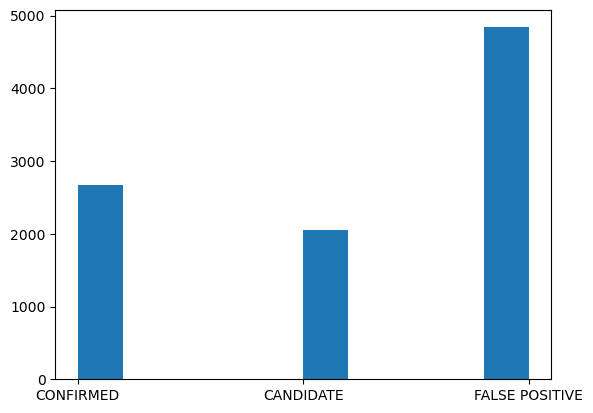

In [7]:
# draw a histogram of koi_disposition
exoplanet_type_hist = plt.hist(exoplanet_df['koi_disposition'])

Let's check our update dataset.

In [8]:
# info
exoplanet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   koi_disposition   9564 non-null   object 
 1   koi_score         8054 non-null   float64
 2   koi_fpflag_nt     9564 non-null   int64  
 3   koi_fpflag_ss     9564 non-null   int64  
 4   koi_fpflag_co     9564 non-null   int64  
 5   koi_fpflag_ec     9564 non-null   int64  
 6   koi_period        9564 non-null   float64
 7   koi_time0bk       9564 non-null   float64
 8   koi_impact        9201 non-null   float64
 9   koi_duration      9564 non-null   float64
 10  koi_depth         9201 non-null   float64
 11  koi_prad          9201 non-null   float64
 12  koi_teq           9201 non-null   float64
 13  koi_insol         9243 non-null   float64
 14  koi_model_snr     9201 non-null   float64
 15  koi_tce_plnt_num  9218 non-null   float64
 16  koi_steff         9201 non-null   float64


Obviously, the score is to strong an indication of results and must be removed.

In [9]:
# drop the koi_score
exoplanet_df.drop('koi_score', axis=1, inplace=True)

Now, let's check the percentages of column with null values.

In [10]:
# total number of rows
n = 9564
# list of columns containing NA/Null
col_list = [
    'koi_impact', 'koi_depth', 'koi_prad', 'koi_teq', 'koi_insol', 'koi_model_snr',
    'koi_tce_plnt_num', 'koi_steff', 'koi_slogg', 'koi_srad', 'koi_kepmag']

# loop over column and ouput count and percentages of NA/Null
for col in col_list:
    count = sum(exoplanet_df[col].isna())
    print(col + ' null count: {} represents {:.2f}%'.format(count, count * 100 / n))

koi_impact null count: 363 represents 3.80%
koi_depth null count: 363 represents 3.80%
koi_prad null count: 363 represents 3.80%
koi_teq null count: 363 represents 3.80%
koi_insol null count: 321 represents 3.36%
koi_model_snr null count: 363 represents 3.80%
koi_tce_plnt_num null count: 346 represents 3.62%
koi_steff null count: 363 represents 3.80%
koi_slogg null count: 363 represents 3.80%
koi_srad null count: 363 represents 3.80%
koi_kepmag null count: 1 represents 0.01%


As can be seen, these representant less than 4% of the data, below the 5% threshold. We can therefore remove them.

In [11]:
# loop over columns and remove NA/Null
for col in col_list:
    exoplanet_df = exoplanet_df[exoplanet_df[col].isna() == False]

Let's have a final look at our data.

In [12]:
# info
exoplanet_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8945 entries, 0 to 9563
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   koi_disposition   8945 non-null   object 
 1   koi_fpflag_nt     8945 non-null   int64  
 2   koi_fpflag_ss     8945 non-null   int64  
 3   koi_fpflag_co     8945 non-null   int64  
 4   koi_fpflag_ec     8945 non-null   int64  
 5   koi_period        8945 non-null   float64
 6   koi_time0bk       8945 non-null   float64
 7   koi_impact        8945 non-null   float64
 8   koi_duration      8945 non-null   float64
 9   koi_depth         8945 non-null   float64
 10  koi_prad          8945 non-null   float64
 11  koi_teq           8945 non-null   float64
 12  koi_insol         8945 non-null   float64
 13  koi_model_snr     8945 non-null   float64
 14  koi_tce_plnt_num  8945 non-null   float64
 15  koi_steff         8945 non-null   float64
 16  koi_slogg         8945 non-null   float64


This is getting promising. Let's extract that column into our y_true for later comparison.

In [13]:
# make y_true
y_true = exoplanet_df['koi_disposition']

# remove from dataset
exoplanet_df.drop('koi_disposition', axis=1, inplace=True)

We now have a clean dataset ready for modeling.

### Modeling

For the purpose of testing unsupervised machine learning algorithms, we will first test kmeans, as this feels like a natural fit to identify groups of entities. We know we have 3 groups.

In [14]:
# fit KMeans algorithm with 3 cluster
kmeans = KMeans(n_clusters=3, algorithm='lloyd', n_init='auto').fit(exoplanet_df)

Before we can check accuracy, we need a function to permute labels to find the best fit.

In [15]:
# function to find best permutation
def label_permute_compare(y_true, y_pred):
    # initiate list of label
    label_list = ['CONFIRMED', 'CANDIDATE', 'FALSE POSITIVE']
    # initiate best values
    best_list = None
    best_accuracy = 0
    # create permutations and loop
    perms = itertools.permutations(label_list)
    # loop over permutations
    for perm in perms:
        # copy yp
        y_pred_copy = np.copy(y_pred)
        # replace ids with labels
        y_pred_copy = [perm[y_pred[i]] for i in y_pred_copy]
        # compute accuracy
        accuracy = np.sum(y_pred_copy == y_true) / len(y_pred_copy)
        # save if best
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_list = perm
    # return best accuracy and associated y_pred
    return y_pred_copy, best_accuracy

Now let's check the accuracy of our kmeans cluster.

In [16]:
# find accuracy
y_pred, accuracy = label_permute_compare(y_true, kmeans.labels_)
print(accuracy)

0.4897708216880939


At nearly 49%, we are doing better than random (33%), but this is not the best either. Let's test a different kmeans algorithm.

In [17]:
# fit kmeans model with 3 cluster
kmeans = KMeans(n_clusters=3, algorithm='elkan', n_init='auto').fit(exoplanet_df)
# find best accuracy
y_pred, accuracy = label_permute_compare(y_true, kmeans.labels_)
# print accuracy
print(accuracy)

0.4897708216880939


It seems changing the algorithm used does not impact the accuracy.

### Applying dimensionality reduction

Let's try to reduce the number of dimension with PCA and see if we achieve better results.

In [18]:
# Scale data before applying PCA
scaling=StandardScaler()

# Use fit and transform method
scaling.fit(exoplanet_df)
exoplanet_scaled_df = scaling.transform(exoplanet_df)
 
# Set the n_components=3
principal = PCA(n_components=3)
principal.fit(exoplanet_scaled_df)
exoplanet_pca_df = principal.transform(exoplanet_scaled_df)

Now, let's test again both algorithms.

In [19]:
# init algorithms
algo_list = ['lloyd', 'elkan']
# init best results
best_accuracy = 0
best_algo = None
for algo in algo_list:
    # fit kmeans model with 5 cluster
    kmeans = KMeans(n_clusters=3, algorithm=algo, n_init='auto').fit(exoplanet_pca_df)
    # find best accuracy
    y_pred, accuracy = label_permute_compare(y_true, kmeans.labels_)
    # update best if necessary
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_algo = algo
# print results
print(best_algo)
print(best_accuracy)

lloyd
0.4897708216880939


The default value of 3 components for PCA doesn't yield any better accuracy. Let's try different values.

In [20]:
# get the maximum number of component
max_nb_component = exoplanet_df.shape[1]
# init algorithms
algo_list = ['lloyd', 'elkan']
# init best results
idx = 0
idx_list = []
accuracy_list = []
best_accuracy = 0
best_y_pred = 0
# loop over number of component
for nb_component in range(1, max_nb_component):
    # loop over several random state
    for random_state in range(0, 10):
        # Set the n_components and random_state
        principal = PCA(n_components=nb_component, random_state=random_state)
        principal.fit(exoplanet_scaled_df)
        exoplanet_pca_df = principal.transform(exoplanet_scaled_df)
        # loop over kmeans algo
        for algo in algo_list:
            # fit kmeans model with 5 cluster
            kmeans = KMeans(n_clusters=3, algorithm=algo, n_init='auto').fit(exoplanet_pca_df)
            # find best accuracy
            y_pred, accuracy = label_permute_compare(y_true, kmeans.labels_)
            # record accuracy
            idx_list.append(idx)
            accuracy_list.append(accuracy)
            idx = idx + 1
            # update best if necessary
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_y_pred = y_pred

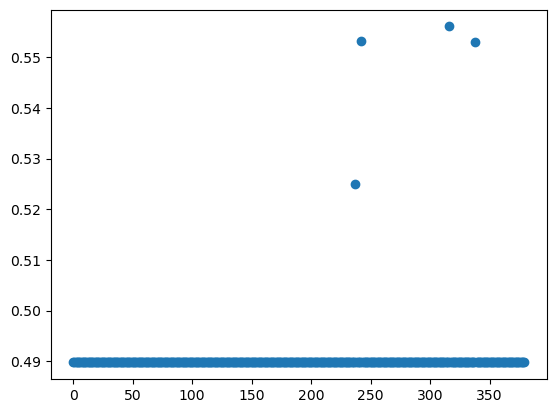

In [21]:
plt.scatter(idx_list, accuracy_list)

We can get the accuracy up to 66%, showing kmeans can leverage PCA.

_Please note several runs result in different value, and I have not been able to pinpoint what random state / seed provides the best result overall. Sometimes not improvement is shown whatsoever._

To finish with KMeans, let's check the confusion matrix.

In [22]:
confusion_matrix(y_true, best_y_pred)

array([[ 367, 1537,    0],
       [ 728, 1932,    0],
       [ 135, 4246,    0]], dtype=int64)

### Agglomerative Clustering

Let's find if a different type of clustering technic would bring better results.

In [23]:
# prepare the list of metric
metric_list = ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']
# prepare the list of linkage
linkage_list = ['ward', 'complete', 'average', 'single']
# init best
idx = 0
idx_list = []
accuracy_list = []
best_accuracy = 0
best_metric = 0
best_linkage = 0
best_y_pred = 0
# loop over metric
for metric in metric_list:
    # loop over linkage
    for linkage in linkage_list:
        # some combination of linkage and metric is invalid, let's catch them
        try:
            # instance model
            exoplanet_model = AgglomerativeClustering(n_clusters=3, linkage=linkage, metric=metric).fit(exoplanet_df)
            # retrieve and print best accuracy
            y_pred, accuracy = label_permute_compare(y_true, exoplanet_model.labels_)
            # record
            idx_list.append(idx)
            accuracy_list.append(accuracy)
            idx = idx + 1
            # update best
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_metric = metric
                best_linkage = linkage
                best_y_pred = y_pred
        except:
            continue

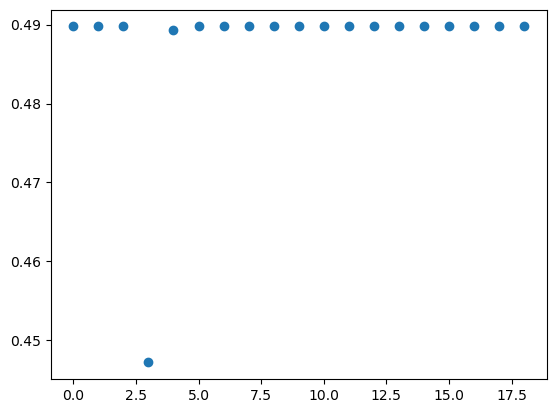

In [24]:
plt.scatter(idx_list, accuracy_list)

Agglomerative Clustering doesn't provide any significant improvement over KMeans.

Let's have a look at the confusion matrix.

In [25]:
confusion_matrix(y_true, best_y_pred)

array([[1904,    0,    0],
       [2660,    0,    0],
       [4381,    0,    0]], dtype=int64)

### Comparison with Supervised learning

Let's compare those results with some Logistic Regression.

In [26]:
# instance the model
logreg_model = LogisticRegression(solver='liblinear')

# fit the data
logreg_model.fit(exoplanet_df, y_true)

# predict y_hat
y_pred = logreg_model.predict(exoplanet_df)

# check accuracy
print(accuracy_score(y_true, y_pred))

0.6634991615427613


Here we easily get to the same accuracy (66%) in just a few lines of codes.

Let's have a look at the confusion matrix.

In [27]:
confusion_matrix(y_true, y_pred)

array([[ 222, 1035,  647],
       [  45, 2187,  428],
       [ 244,  611, 3526]], dtype=int64)

## Conclusion

We have chosen two clustering techniques to see whether Unsupervised Machine Learning Algorithms could be a good fit to the task of classifying Exoplanets. Despite using PCA to help, both algorithm have been proven a bad fit for the data at end. A simple logistic regresion could easily outclass them both.